In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal, fft
import math as math
import os

# Import and look at data

In [3]:
# import data
# change path name to wherever you saved your data
path = 'D:/Momona/Google Drive2/NEW Yamagami Lab/Projects/hcps/UG/Alexis/sensorfusion/analysis/EMG signal quality analysis/delsys-data'
files = os.listdir(path)    
files = list(filter(lambda f: f.endswith('.csv'), files))
data = pd.read_csv(os.path.join(path,files[0]),
                   names=["Time", "Biceps (V)", "Triceps (V)"])

In [4]:
data.head()

,Time,Biceps (V),Triceps (V)
0,2019-06-30-15:58:46,-0.000086,0.000032
1,2019-06-30-15:58:46,-0.000087,0.000029
2,2019-06-30-15:58:46,-0.000089,0.000025
3,2019-06-30-15:58:46,-0.000091,0.000024
4,2019-06-30-15:58:46,-0.000089,0.000026


In [5]:
# determine sampling frequency
fs = 1926.
len(data)/1926

46.690031152647975

## first plot time-domain signal for biceps and triceps

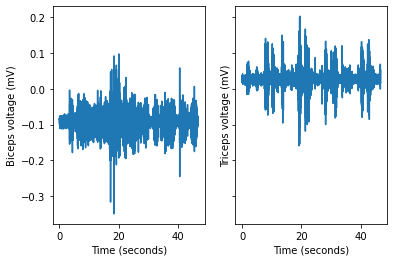

In [6]:
# plot time domain signals
fig,[ax1,ax2] = plt.subplots(1,2,sharex=True,sharey=True)
ax1.plot(np.linspace(0,len(data)/fs,len(data)),data["Biceps (V)"]*1000)
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("Biceps voltage (mV)")
ax2.plot(np.linspace(0,len(data)/fs,len(data)),data["Triceps (V)"]*1000)
ax2.set_xlabel("Time (seconds)")
ax2.set_ylabel("Triceps voltage (mV)")
plt.show()

## plot after demeaning the EMG signal

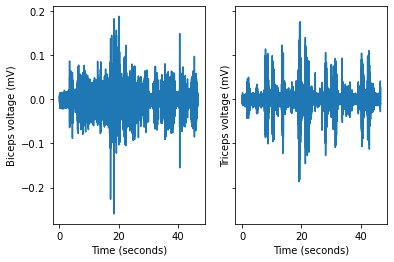

In [7]:
# plot time domain signals
data["bic_demean"]= data["Biceps (V)"].values-np.mean(data["Biceps (V)"].values)
data["tri_demean"]= data["Triceps (V)"].values-np.mean(data["Triceps (V)"].values)                                                    
                                                      
fig,[ax1,ax2] = plt.subplots(1,2,sharex=True,sharey=True)
ax1.plot(np.linspace(0,len(data)/fs,len(data)),data["bic_demean"]*1000)
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("Biceps voltage (mV)")
ax2.plot(np.linspace(0,len(data)/fs,len(data)),data["tri_demean"]*1000)
ax2.set_xlabel("Time (seconds)")
ax2.set_ylabel("Triceps voltage (mV)")
plt.show()

## plot FFT

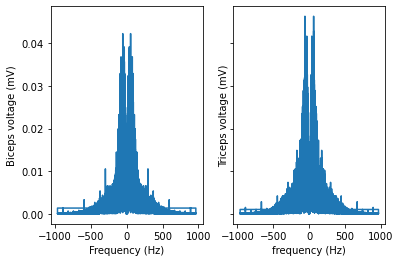

In [8]:
N = len(data)
T = 1./fs
xf = fft.fftfreq(N, 1 / fs)
# x = np.linspace(0.0, T*N, N)
# plot frequency domain signal for triceps
data["tri_fft"] = fft.fft(data["tri_demean"].values)
data["bic_fft"] = fft.fft(data["bic_demean"].values)

fig,[ax1,ax2] = plt.subplots(1,2,sharex=True,sharey=True)
ax1.plot(xf,abs(data["bic_fft"]))
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Biceps voltage (mV)")
ax2.plot(xf,np.abs(data["tri_fft"].values))
ax2.set_xlabel("frequency (Hz)")
ax2.set_ylabel("Triceps voltage (mV)")
plt.show()

# Compute RMS

## Step 1. high pass filter 

4th order butterworth at 40Hz

Use second order format when filtering to avoid numerical error

<ipython-input-9-204a27202e69>:5: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(w, 20 * np.log10(abs(h)))


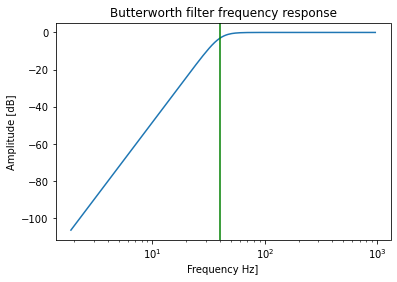

In [9]:
# CREATE AND PLOT BUTTERWORTH FILTER
sos = signal.butter(N=4,Wn=40,btype='hp',fs=fs, output='sos')
# plot butterworth filter
w, h = signal.sosfreqz(sos=sos,fs=fs)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency Hz]')
plt.ylabel('Amplitude [dB]')
# plt.margins(0, 0.1)
# plt.grid(which='both', axis='both')
plt.axvline(40, color='green') # cutoff frequency
plt.show()

In [10]:
# FILTER THE DATA 
data["bic_hp"] = signal.sosfiltfilt(sos=sos,x=data["bic_demean"].values)
data["tri_hp"] = signal.sosfiltfilt(sos=sos,x=data["tri_demean"].values)

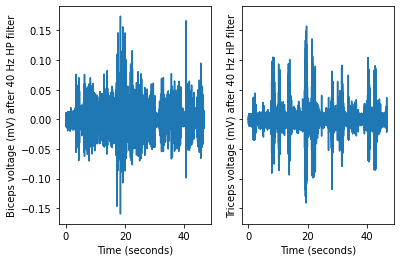

In [11]:
# PLOT THE FILTERED DATA
fig,[ax1,ax2] = plt.subplots(1,2,sharex=True,sharey=True)
ax1.plot(np.linspace(0,len(data)/fs,len(data)),data["bic_hp"]*1000)
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("Biceps voltage (mV) after 40 Hz HP filter")
ax2.plot(np.linspace(0,len(data)/fs,len(data)),data["tri_hp"]*1000)
ax2.set_xlabel("Time (seconds)")
ax2.set_ylabel("Triceps voltage (mV) after 40 Hz HP filter")
plt.show()

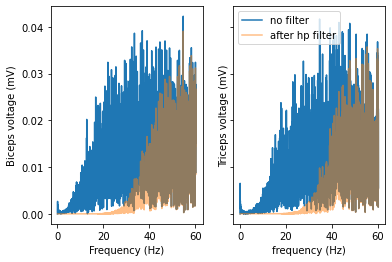

In [12]:
# PLOT IN FREQ DOMAIN AND COMPARE AGAINST UNFILTERED
data["tri_hp_fft"] = fft.fft(data["tri_hp"].values)
data["bic_hp_fft"] = fft.fft(data["bic_hp"].values)
divby = 32

fig,[ax1,ax2] = plt.subplots(1,2,sharex=True,sharey=True)
ax1.plot(xf[:int(N/divby)],abs(data["bic_fft"])[:int(N/divby)],label='no filter')
ax1.plot(xf[:int(N/divby)],abs(data["bic_hp_fft"])[:int(N/divby)],label='after hp filter',alpha=0.5)
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Biceps voltage (mV)")
ax2.plot(xf[:int(N/divby)],np.abs(data["tri_fft"].values[:int(N/divby)]),label='no filter')
ax2.plot(xf[:int(N/divby)],np.abs(data["tri_hp_fft"].values[:int(N/divby)]),label='after hp filter',alpha=0.5)
ax2.set_xlabel("frequency (Hz)")
ax2.set_ylabel("Triceps voltage (mV)")
plt.legend()
plt.show()

## Step 2: Rectification (abs everything)

In [13]:
data["bic_rect"] = abs(data["bic_hp"])
data["tri_rect"] = abs(data["tri_hp"])

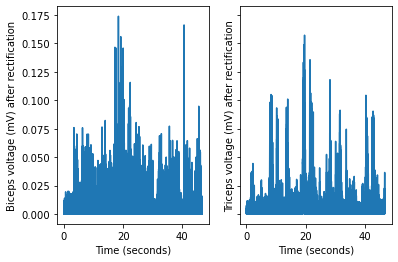

In [14]:
fig,[ax1,ax2] = plt.subplots(1,2,sharex=True,sharey=True)
ax1.plot(np.linspace(0,len(data)/fs,len(data)),data["bic_rect"]*1000)
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("Biceps voltage (mV) after rectification")
ax2.plot(np.linspace(0,len(data)/fs,len(data)),data["tri_rect"]*1000)
ax2.set_xlabel("Time (seconds)")
ax2.set_ylabel("Triceps voltage (mV) after rectification")
plt.show()

## Step 3: low pass filter

40 Hz low pass filter 4th order butterworth

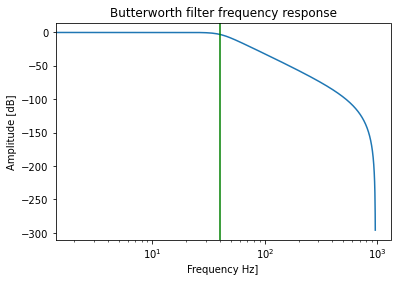

In [15]:
sos = signal.butter(N=4,Wn=40,btype='lowpass',fs=fs, output='sos')
# plot butterworth filter
w, h = signal.sosfreqz(sos=sos,fs=fs)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency Hz]')
plt.ylabel('Amplitude [dB]')
# plt.margins(0, 0.1)
# plt.grid(which='both', axis='both')
plt.axvline(40, color='green') # cutoff frequency
plt.show()

In [16]:
# FILTER THE DATA 
data["bic_lp"] = signal.sosfiltfilt(sos=sos,x=data["bic_rect"].values)
data["tri_lp"] = signal.sosfiltfilt(sos=sos,x=data["tri_rect"].values)

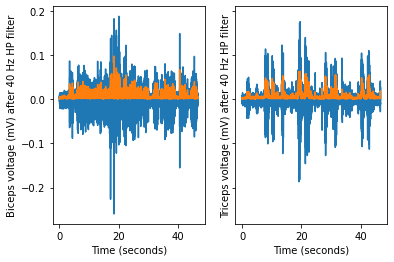

In [17]:
# PLOT THE FILTERED DATA
fig,[ax1,ax2] = plt.subplots(1,2,sharex=True,sharey=True)
ax1.plot(np.linspace(0,len(data)/fs,len(data)),data["bic_demean"]*1000)
ax1.plot(np.linspace(0,len(data)/fs,len(data)),data["bic_lp"]*1000)
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("Biceps voltage (mV) after 40 Hz HP filter")
ax2.plot(np.linspace(0,len(data)/fs,len(data)),data["tri_demean"]*1000)
ax2.plot(np.linspace(0,len(data)/fs,len(data)),data["tri_lp"]*1000)
ax2.set_xlabel("Time (seconds)")
ax2.set_ylabel("Triceps voltage (mV) after 40 Hz HP filter")
plt.show()



In [18]:
# divby = 32
# # PLOT IN FREQ DOMAIN AND COMPARE AGAINST UNFILTERED
# data["tri_lp_fft"] = fft.fft(data["tri_lp"].values-np.mean(data["tri_lp"].values))
# data["bic_lp_fft"] = fft.fft(data["bic_lp"].values-np.mean(data["bic_lp"].values))

# fig,[ax1,ax2] = plt.subplots(1,2,sharex=True,sharey=True)
# ax1.plot(xf[:int(N/divby)],abs(data["bic_fft"])[:int(N/divby)],label='no filter')
# ax1.plot(xf[:int(N/divby)],abs(data["bic_lp_fft"])[:int(N/divby)],label='after lp filter',alpha=0.5)
# ax1.set_xlabel("Frequency (Hz)")
# ax1.set_ylabel("Biceps voltage (mV)")
# ax2.plot(xf[:int(N/divby)],np.abs(data["tri_fft"].values[:int(N/divby)]),label='no filter')
# ax2.plot(xf[:int(N/divby)],np.abs(data["tri_lp_fft"].values[:int(N/divby)]),label='after lp filter',alpha=0.5)
# ax2.set_xlabel("frequency (Hz)")
# ax2.set_ylabel("Triceps voltage (mV)")
# plt.legend()
# plt.show()

## Step 4: Compute RMS

use sliding window that is 300 ms long

$$x_{rms}=\sqrt{\frac{1}{N}\sum^N_{n=1}|x_n|^2}$$

In [ ]:
window = np.ceil(0.3*fs)

bic_rms = []
for idx in range(int(len(data["bic_lp"])-window)):
    bic_rms.append(np.sqrt(1/window*np.sum([abs(x)**2 for x in data["bic_lp"].values[idx:int(idx+window)]])))
bic_rms = np.asarray(bic_rms)

tri_rms = []
for idx in range(int(len(data["tri_lp"])-window)):
    tri_rms.append(np.sqrt(1/window*np.sum([abs(x)**2 for x in data["tri_lp"].values[idx:int(idx+window)]])))
tri_rms = np.asarray(tri_rms)

In [ ]:
fig,[ax1,ax2] = plt.subplots(1,2,sharex=True,sharey=False)
ax1.plot(np.linspace(0,len(data)/fs,len(data)),abs(data["bic_lp"])*1000)
ax1.plot(np.linspace(0,len(bic_rms)/fs,len(bic_rms)),bic_rms*1000)
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("Biceps voltage (mV)")
ax2.plot(np.linspace(0,len(data)/fs,len(data)),abs(data["tri_lp"])*1000,label="filtered EMG data")
ax2.plot(np.linspace(0,len(tri_rms)/fs,len(tri_rms)),tri_rms*1000,label="RMS")
ax2.set_xlabel("Time (seconds)")
ax2.set_ylabel("Triceps voltage (mV)")
plt.legend()
plt.tight_layout()

plt.show()

# Compute Power spectral density

Welch's PSD estimate with 50% overlap 

In [ ]:
f, Pxx_bic = signal.welch(data["bic_demean"].values, fs=fs,detrend=False)
f, Pxx_tri = signal.welch(data["tri_demean"].values, fs=fs,detrend=False)
plt.semilogy(f, Pxx_bic,"-o",label='biceps')
plt.semilogy(f, Pxx_tri,"-o",label='triceps')
plt.legend()
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

# Compute SNR

noise power is the sum of the PSD across the upper 20% ferq range

total power is the sum of the PSD across all frequencies

In [ ]:
# upper 20%
f_ind_upper = range(int(len(f)*4/5),len(f))#[ n for n,i in enumerate(f) if i>400 ]
print(f[f_ind_upper[0]])
noise_power = np.sum(Pxx_bic[f_ind_upper])/len(f_ind_upper)*len(f)
print(noise_power)
total_power = np.sum(Pxx_bic)
print(total_power)
SN_bic = total_power/noise_power
print("bicep SNR:", np.round(10*np.log10(SN_bic),2))

In [ ]:
noise_power = np.sum(Pxx_tri[f_ind_upper])/len(f_ind_upper)*len(f)
print(noise_power)
total_power = np.sum(Pxx_tri)
print(total_power)
SN_tri = total_power/noise_power
print("tri SNR:", np.round(10*np.log10(SN_tri),2))

# Compute SMR

assumptions:

1. freq of motion artifacts are below 20 Hz

2. shapres of non-contaminated EMG power spectrum is fairly linear below 20 Hz

SMR = ratio of the sum of all power desnities for all freqs below 600 Hz and and sum of all power densities below 20 Hz that exceed a straight line between axis origin and highest mean power density above 35 Hz 

compute mean power density by averaging 13 consecutive points in the EMG power spectrum

In [ ]:
# get freqs below 600 Hz
f_600_indx = [ n for n,i in enumerate(f) if i<600 ] # get the indices of freqs below 600 Hz
f_600 = f[f_600_indx]
Pxx_bic_600 = Pxx_bic[f_600_indx]
Pxx_tri_600 = Pxx_tri[f_600_indx]

## Compute mean PSD and find highest PSD above 35 Hz
over 13 points

In [ ]:
# average PSD over N points using N/2 points before and after
N = 13
b = np.squeeze(np.ones((N,1))/N)
a = 1
mean_psd_bic = signal.lfilter(b,a,np.hstack([Pxx_bic_600,(np.squeeze(np.zeros((int(np.floor(N/2)),1))))]))
mean_psd_bic = mean_psd_bic[int(np.floor(N/2)):]

mean_psd_tri = signal.lfilter(b,a,np.hstack([Pxx_tri_600,(np.squeeze(np.zeros((int(np.floor(N/2)),1))))]))
mean_psd_tri = mean_psd_tri[int(np.floor(N/2)):]

In [ ]:
# find index that is above 35 Hz for bic
f_indx_above_35 = [x[0] for x in enumerate(f_600) if x[1] > 35]
highest_mean_psd = max(mean_psd_bic[f_indx_above_35])
f_highest_mean_psd = f_600[int(np.argmax(mean_psd_bic[f_indx_above_35])+(len(f_600)-len(f_indx_above_35)))]
f_highest_mean_psd_indx = int(np.argmax(mean_psd_bic[f_indx_above_35])+(len(f_600)-len(f_indx_above_35))) 
print("highest mean psd above 35 Hz for bic is: ", highest_mean_psd)

# find index that is above 35 Hz for tri
highest_mean_psd_tri = max(mean_psd_tri[f_indx_above_35])
f_highest_mean_psd_tri = f_600[int(np.argmax(mean_psd_tri[f_indx_above_35])+(len(f_600)-len(f_indx_above_35)))]
f_highest_mean_psd_indx_tri = int(np.argmax(mean_psd_tri[f_indx_above_35])+(len(f_600)-len(f_indx_above_35))) 
print("highest mean psd above 35 Hz for tri is: ", highest_mean_psd_tri)

## find data that is above slope 

In [ ]:
# find all data that is below the slope between highest point and (0,0)) bic
f_indx_below_20 = [x[0] for x in enumerate(f_600) if x[1] < 20]
slope = highest_mean_psd/f_highest_mean_psd
indx_exceed_line = [x[0] for x in enumerate(Pxx_bic_600[f_indx_below_20]) if x[1] > slope*f_600[x[0]]]

# find all data that is below the slope between highest point and (0,0)) tri
slope_tri = highest_mean_psd_tri/f_highest_mean_psd_tri
indx_exceed_line_tri = [x[0] for x in enumerate(Pxx_tri_600[f_indx_below_20]) if x[1] > slope_tri*f_600[x[0]]]

In [ ]:
fig,[ax1,ax2] = plt.subplots(1,2,sharex=True,sharey=False)
ax1.plot(f_600,Pxx_bic_600,"-o",label="original PSD")
ax1.plot(f_600,mean_psd_bic,label="mean PSD")
ax1.scatter(f_highest_mean_psd,highest_mean_psd, label='max above 35 Hz')
ax1.plot(f_600[:f_highest_mean_psd_indx+1],f_600[:f_highest_mean_psd_indx+1]*slope,label='linear line')
ax1.set_xlim((0,50))

ax2.plot(f_600,Pxx_tri_600,"-o",label="original PSD")
ax2.plot(f_600,mean_psd_tri,label="mean PSD")
ax2.scatter(f_highest_mean_psd_tri,highest_mean_psd_tri, label='max above 35 Hz')
ax2.plot(f_600[:f_highest_mean_psd_indx_tri+1],f_600[:f_highest_mean_psd_indx_tri+1]*slope_tri,label='linear line')
ax2.set_xlim((0,50))

ax1.legend()
plt.show()

In [ ]:
# compute power above line
power_above_line = np.sum(Pxx_bic_600[indx_exceed_line])
total_power = np.sum(Pxx_bic_600)
SM_bic = total_power/power_above_line
print("SMR for biceps: ", np.round(10*np.log10(SM_bic),2))

In [ ]:
# compute power above line
power_above_line = np.sum(Pxx_tri_600[indx_exceed_line_tri])
total_power = np.sum(Pxx_tri_600)
SM_tri = total_power/power_above_line
print("SMR for triceps: ", np.round(10*np.log10(SM_tri),2))